In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.ticker import MaxNLocator

In [2]:
df_train = pd.read_csv('df_train.csv')
df_test  = pd.read_csv('df_test.csv')

In [3]:
# df_train

## Explonatory Data Analysis

Independent variable (Target) is `SalePrice`

In [4]:
df_train.SalePrice.dtypes

dtype('int64')

1.8828757597682129


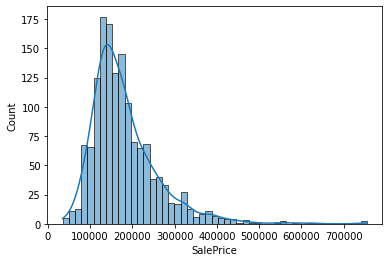

In [5]:
sns.histplot(data=df_train,x="SalePrice", kde=True)
print(df_train.SalePrice.skew())

We will adjust skewness later

In [6]:
numerical_features = list(df_train.select_dtypes('number').columns[:-1])
categorical_features = list(df_train.select_dtypes('object').columns)

print('The number of numerical features is ', len(numerical_features)) 
print('The number of catergorical features is ', len(categorical_features)) 

The number of numerical features is  33
The number of catergorical features is  28


### Numerical data

we separate numerical features whose number of unique values <= 30 

In [7]:
numerical_features_less_30 = list(df_train[numerical_features].nunique()
                              .iloc[df_train[numerical_features].nunique().values<=30].index)
numerical_features_more_30 = [x for x in numerical_features if x not in numerical_features_less_30]

#### Numerical features whose number of unique values is $>30$ 

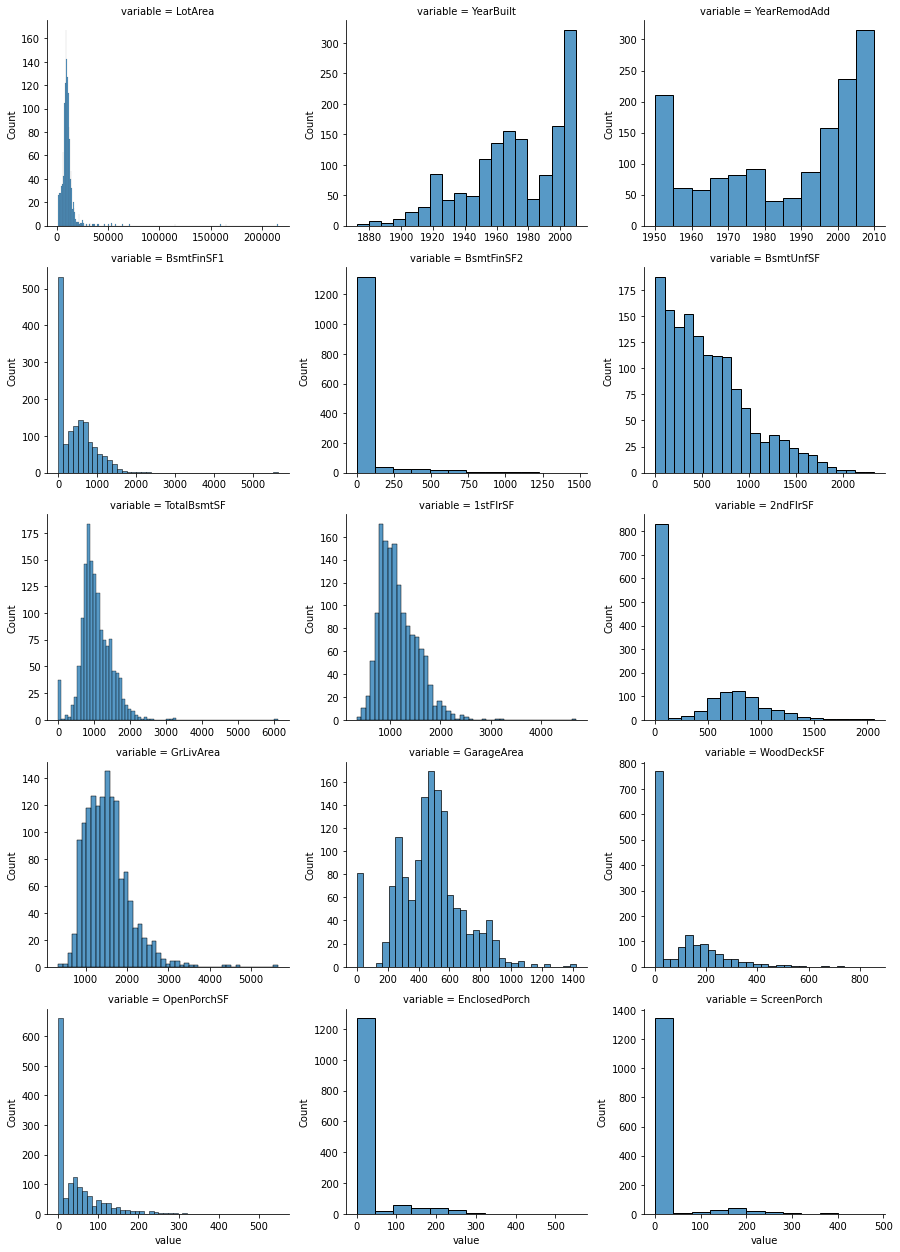

In [8]:
f = pd.melt(df_train[numerical_features_more_30])
fg = sns.FacetGrid(f, col='variable',  col_wrap=3,sharex=False, sharey=False,height=3.5, aspect=1.2)
fg.map(sns.histplot, "value")

In [9]:
numerical_features_more_30 =['LotArea', 'TotalBsmtSF','1stFlrSF','GrLivArea','GarageArea']

Adjust skewness

In [10]:
df_train[numerical_features_more_30].describe().min()

LotArea        1300.0
TotalBsmtSF       0.0
1stFlrSF        334.0
GrLivArea       334.0
GarageArea        0.0
dtype: float64

In [11]:
adjusted_features = numerical_features_more_30 + ['SalePrice']
df_train[adjusted_features] = df_train[adjusted_features]/df_train[adjusted_features].mean() + 1

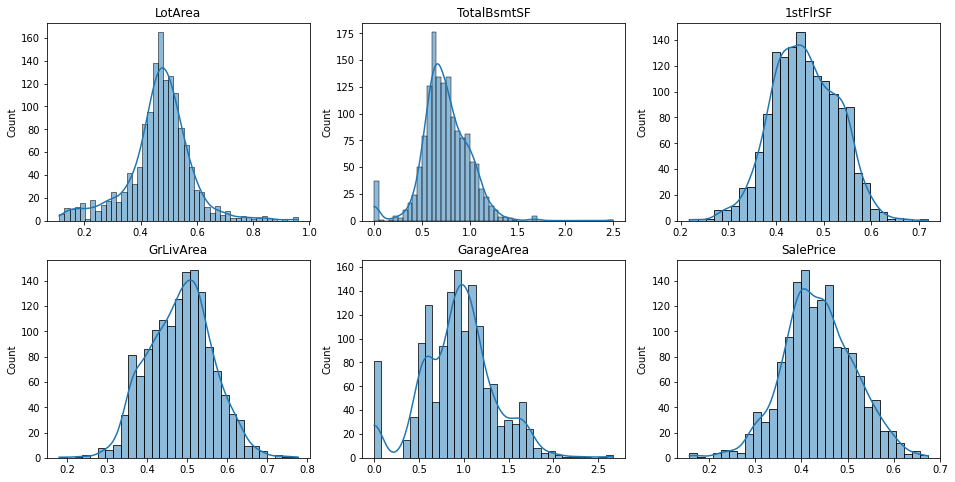

In [12]:
nrows = len(adjusted_features)//3 
fig, axs = plt.subplots(ncols=3,nrows=nrows,figsize=(16,8))
for i in range(nrows):
    for j in range(3):
        ftr = adjusted_features[3*i+j]
        xt, _ = stats.boxcox(df_train[ftr])
        sns.histplot(data=xt, kde=True,ax=axs[i][j])
        axs[i][j].set_title(ftr)
        df_train[ftr] = xt

### Categorical

In [13]:
# This function presents all the boxplots of categorical preditors with SalePrice
def srt_box(y, df):
    fig, axes = plt.subplots(11, 3, figsize=(20, 70))
    axes = axes.flatten()

    for i, j in zip(df.select_dtypes(include=['category']).columns, axes):

        sortd = df.groupby([i])[y].median().sort_values(ascending=True)
        sns.boxplot(x=i,
                    y=y,
                    data=df,
                    palette='plasma',
                    order=sortd.index,
                    ax=j)
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(MaxNLocator(nbins=18))

        plt.tight_layout()

In [14]:
categorical = categorical_features + numerical_features_less_30
df_categorical = df_train[categorical].astype('category',copy=False)
df_categorical['SalePrice'] = df_train['SalePrice']
df_categorical

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,3SsnPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,1,8,0,2,0,0,0,2,2008,0.483517
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,1,6,1,2,0,0,0,5,2007,0.455943
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,1,6,1,2,0,0,0,9,2008,0.497011
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,1,7,1,3,0,0,0,2,2006,0.402928
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,1,9,1,3,0,0,0,12,2008,0.518218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,1,7,1,2,0,0,0,8,2007,0.448579
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,...,1,7,2,2,0,0,0,2,2010,0.484920
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,...,1,9,2,1,0,0,2500,5,2010,0.529967
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,1,5,0,1,0,0,0,4,2010,0.406027


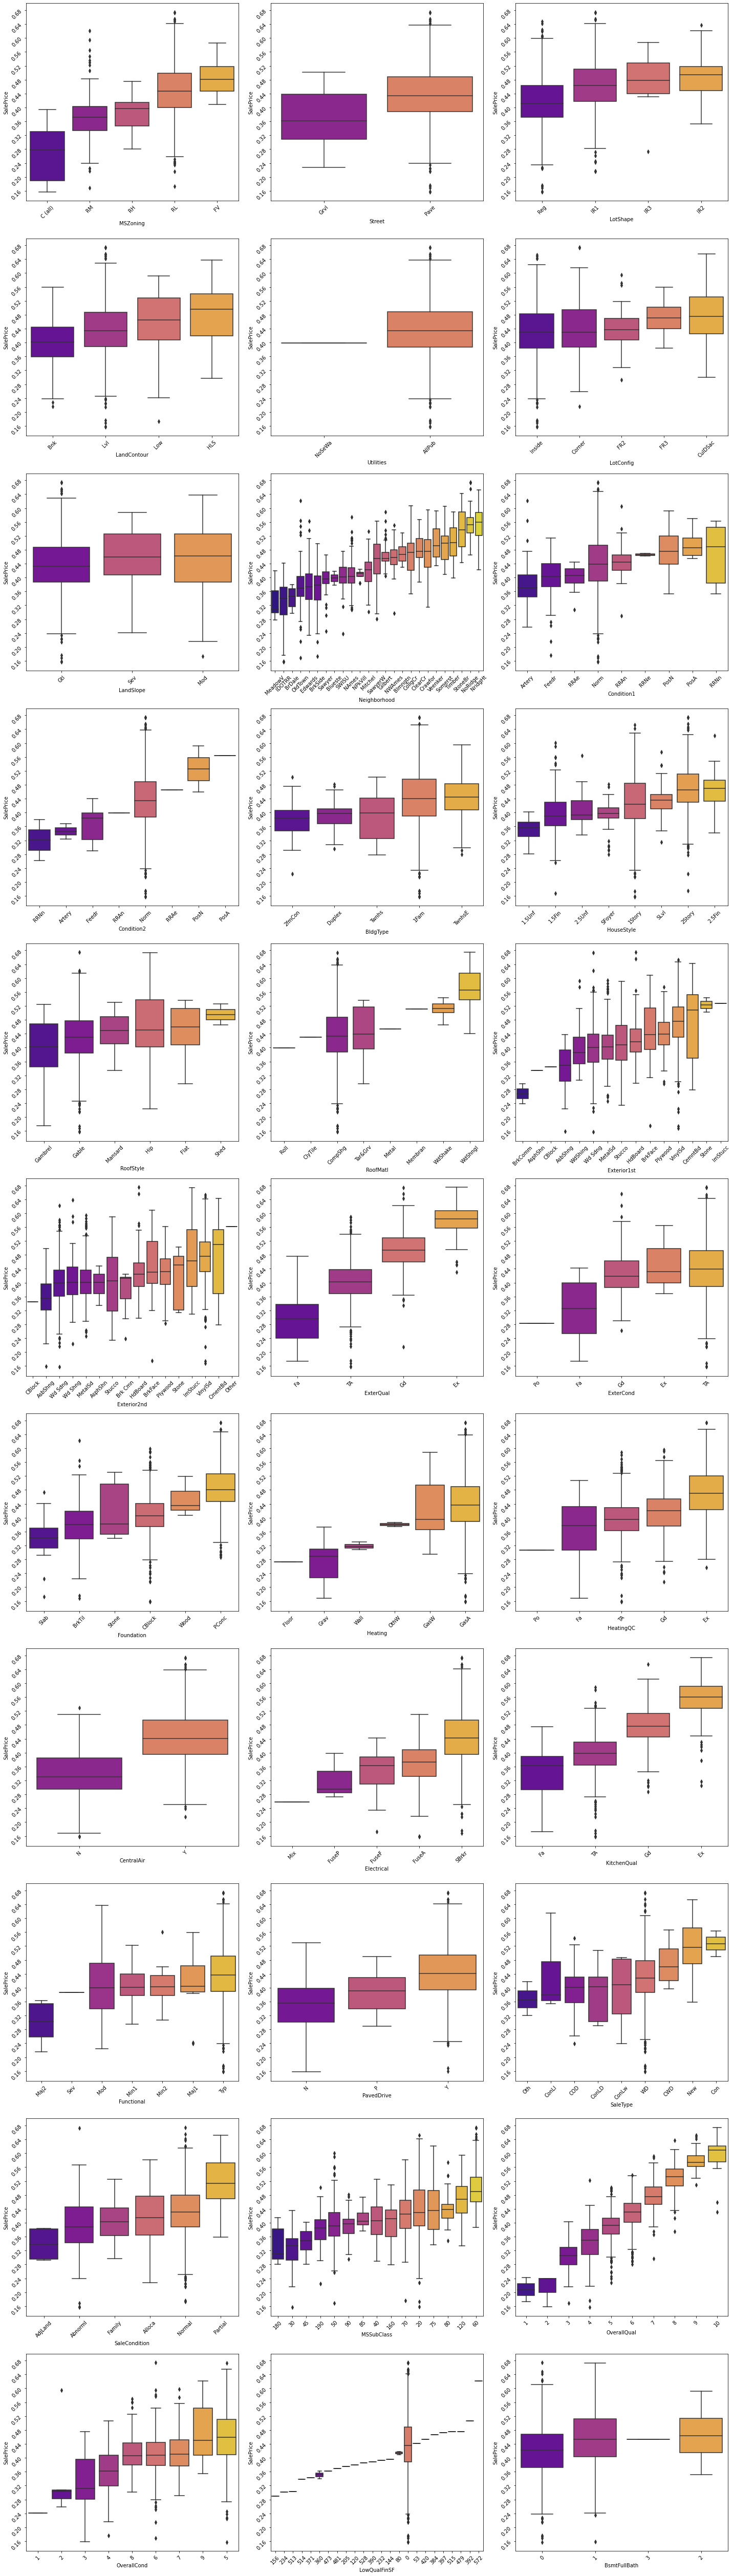

In [15]:
srt_box('SalePrice', df_categorical)

In [16]:
categorical_features = ['Neighborhood','ExterQual','CentralAir','KitchenQual','OverallQual','GarageCars']

kept_features = categorical_features + adjusted_features

df_train = df_train[kept_features]

In [17]:
# Converting the important categorical columns to numeric ones.

# neighborhood
nbd_map = {
    'MeadowV': 1,
    'IDOTRR':  1,
    'BrDale':  1,
    'BrkSide': 1,
    'OldTown': 1,
    'Edwards': 2,
    'Sawyer':  2,
    'Blueste': 2,
    'SWISU':   2,
    'NPkVill': 2,
    'NAmes':   3,
    'Mitchel': 3,
    'SawyerW': 3,
    'NWAmes':  3,
    'Gilbert': 3,
    'Blmngtn': 4,
    'CollgCr': 4,
    'ClearCr': 4,
    'Crawfor': 4,
    'Veenker': 4,
    'Somerst': 5,
    'Timber':  5,
    'StoneBr': 5,
    'NridgHt': 5,
    'NoRidge': 5
}

# ExterQual
EQ_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

# CentralAir
CA_map = {'N': 0, 'Y': 1}

# KitchenQual
KQ_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}


df_train.replace({'Neighborhood': nbd_map,
                  'ExterQual':EQ_map,
                  'CentralAir':CA_map,
                  'KitchenQual':KQ_map
                 }, inplace=True)

df_train[categorical_features] = df_train[categorical_features].astype('int')


In [18]:
df_train.dtypes

Neighborhood      int64
ExterQual         int64
CentralAir        int64
KitchenQual       int64
OverallQual       int64
GarageCars        int64
LotArea         float64
TotalBsmtSF     float64
1stFlrSF        float64
GrLivArea       float64
GarageArea      float64
SalePrice       float64
dtype: object

### Correlations

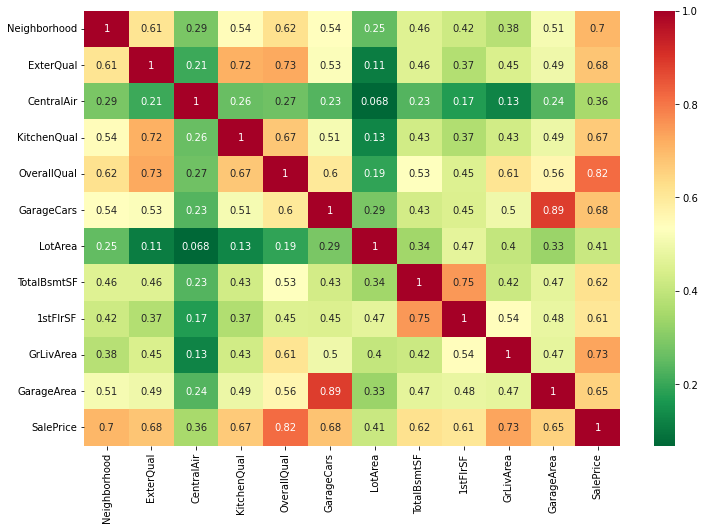

In [19]:
corrmat = df_train.corr()
plt.figure(figsize=(12,8))
g = sns.heatmap(df_train.corr(),annot=True,cmap="RdYlGn_r")

In [20]:
df_train.corr()['SalePrice'].sort_values()

CentralAir      0.355592
LotArea         0.413466
1stFlrSF        0.606063
TotalBsmtSF     0.618304
GarageArea      0.652326
KitchenQual     0.667535
ExterQual       0.677536
GarageCars      0.683126
Neighborhood    0.702593
GrLivArea       0.732050
OverallQual     0.816574
SalePrice       1.000000
Name: SalePrice, dtype: float64

Since the correlation between `SalePrice` with both `CentralAir` and `LotArea` are less than 0.5, we decided to drop these two predictors before fitting the model.

In [21]:
df_train.drop(columns = ['CentralAir', 'LotArea'], inplace=True)

In [22]:
df_train

,Neighborhood,ExterQual,KitchenQual,OverallQual,GarageCars,TotalBsmtSF,1stFlrSF,GrLivArea,GarageArea,SalePrice
0,4,4,4,7,2,0.642487,0.404844,0.525656,1.090793,0.483517
1,4,3,3,6,2,0.873733,0.490420,0.451188,0.922722,0.455943
2,4,4,4,7,2,0.681190,0.420764,0.536259,1.204217,0.497011
3,4,3,4,7,3,0.580067,0.430414,0.526653,1.268097,0.402928
4,5,4,4,8,3,0.810360,0.469126,0.586099,1.627631,0.518218
...,...,...,...,...,...,...,...,...,...,...
1455,3,3,3,6,2,0.700788,0.428563,0.516474,0.922722,0.448579
1456,3,3,3,6,2,1.016395,0.592558,0.572202,0.999381,0.484920
1457,4,5,4,7,1,0.814220,0.477222,0.600778,0.516056,0.529967
1458,3,3,4,5,1,0.772950,0.455834,0.413044,0.492132,0.406027


In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data = scaler.fit_transform(df_train)
df_train = pd.DataFrame(data,
                        columns=df_train.columns,
                        index=df_train.index)
df_train

,Neighborhood,ExterQual,KitchenQual,OverallQual,GarageCars,TotalBsmtSF,1stFlrSF,GrLivArea,GarageArea,SalePrice
0,0.713481,1.052302,0.735994,0.651479,0.311725,-0.412968,-0.816987,0.541410,0.364320,0.604025
1,0.713481,-0.689604,-0.771091,-0.071836,0.311725,0.535810,0.438662,-0.394553,-0.044421,0.246400
2,0.713481,1.052302,0.735994,0.651479,0.311725,-0.254175,-0.583384,0.674684,0.640161,0.779040
3,0.713481,-0.689604,0.735994,0.651479,1.650307,-0.669070,-0.441805,0.553950,0.795512,-0.441204
4,1.478862,1.052302,0.735994,1.374795,1.650307,0.275796,0.126223,1.301102,1.669881,1.054106
...,...,...,...,...,...,...,...,...,...,...
1455,-0.051899,-0.689604,-0.771091,-0.071836,0.311725,-0.173766,-0.468959,0.426012,-0.044421,0.150888
1456,-0.051899,-0.689604,-0.771091,-0.071836,0.311725,1.121135,1.937317,1.126441,0.142011,0.622226
1457,0.713481,2.794208,0.735994,0.651479,-1.026858,0.291634,0.245005,1.485605,-1.033409,1.206486
1458,-0.051899,-0.689604,0.735994,-0.795151,-1.026858,0.122306,-0.068814,-0.873975,-1.091592,-0.401008
